In [73]:
import os
import xarray as xr
import netCDF4 as nc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd


In [2]:
base_dir = '/Users/donghui/Box Sync/Research/PhD/Projects/Water_Supply_Drought'
data_dir = f'{base_dir}/data'
reservoir_data_dir = '/Users/donghui/Box Sync/Research/PhD/Projects/DROM_CONUS_Analysis/Data/HydroShare'
output_dir = f'{data_dir}/results/lrr_output'

os.chdir(base_dir)

In [3]:
# What I'm about to analyze:
# 1. Water deficit: reliability, resilience, vulnerability
# 2. Streamflow drought upstream & downstream of reservoirs
# 3. Water deficit: duration, severity, intensity

# Sustainability Index

In [68]:
# ---- Define reliability, resilience, vulnerability ---- #

def cal_reliability(deficit_array, threshold=0.0001):
    """
    Calculate reliability of water deficit time series for a given grid.
    
    threshold: the threshold of water deficit, above which to be considered as a deficit
    """

    n_deficit = deficit_array[deficit_array > threshold].size

    reliability = 1 - n_deficit / deficit_array.size

    return(reliability)

def cal_resilience(deficit_array, threshold=0.0001):
    """
    Calculate resilience of water deficit time series for a given grid.
        Resilience: number of times a non-deficit day follows a deficit day / number of deficit days
    
    threshold: the threshold of water deficit, above which to be considered as a deficit
    """

    n_deficit = deficit_array[deficit_array > threshold].size
    if n_deficit == 0:    # if there is no deficit, no resilience
        return np.nan
    
    n_resilience = 0

    for i in range(deficit_array.size - 1):
        if deficit_array[i] > threshold and deficit_array[i + 1] <= threshold:
            n_resilience += 1

    resilience = n_resilience / n_deficit
    
    return(resilience)

def cal_vulnerability(deficit_array, threshold=0.0001):
    """
    Calculate vulnerability of water deficit time series for a given grid.
        Vulnerability: sum of deficit amount / number of deficit days
    
    threshold: the threshold of water deficit, above which to be considered as a deficit
    """

    n_deficit = deficit_array[deficit_array > threshold].size
    if n_deficit == 0:    # if there is no deficit, no vulnerability
        return np.nan

    vulnuerability = np.sum(deficit_array[deficit_array > threshold]) / n_deficit

    return(vulnuerability)



In [69]:
# ---- Calculate sustainability index & add to dataset ---- #

huc4 = '1705'

# read simulation results
ds = xr.load_dataset(f'{output_dir}/{huc4}/model_states_{huc4}.nc')

# Omit the first 2 years of spinup
spinup_start = '1988-01-01'
spinup_end = '1990-01-01'
spinup_len = (pd.to_datetime(spinup_end) - pd.to_datetime(spinup_start)).days
# skip the first 2 years of spinup
ds = ds.isel(time=slice(spinup_len, None))

# get the grid indices that locate in the huc4: flow_direction != -1
huc4_lat_lon_tup = np.where(ds['flow_direction'] != -1)    # (lat_ind_array, lon_ind_array) pair

# loop through each grid cell & calculate sustainability index & add to the ds
reliability_array = np.ones_like(ds['water_deficit'].isel(time=0).values) * np.nan
resilience_array = np.ones_like(ds['water_deficit'].isel(time=0).values) * np.nan
vulnerability_array = np.ones_like(ds['water_deficit'].isel(time=0).values) * np.nan
for lat_ind, lon_ind in zip(huc4_lat_lon_tup[0], huc4_lat_lon_tup[1]):
    # get the water deficit time series
    deficit_array = ds['water_deficit'].isel(lat=lat_ind, lon=lon_ind).values
    
    # calculate sustainability index
    reliability = cal_reliability(deficit_array)
    resilience = cal_resilience(deficit_array)
    vulnerability = cal_vulnerability(deficit_array)

    # add to the array
    reliability_array[lat_ind, lon_ind] = reliability
    resilience_array[lat_ind, lon_ind] = resilience
    vulnerability_array[lat_ind, lon_ind] = vulnerability

# add to the ds
ds['reliability'] = (('lat', 'lon'), reliability_array)
ds['resilience'] = (('lat', 'lon'), resilience_array)
ds['vulnerability'] = (('lat', 'lon'), vulnerability_array)



## Visualize Sustainability Index

In [74]:
# ---- Read geospatial files ---- #

nhd_data_dir = '/Users/donghui/Box Sync/Research/PhD/Projects/Drought_Cycle_Analysis/Data'
crs = 'EPSG:4326'
huc2_conus = [f'0{i}' if i<10 else f'{i}' for i in range(1, 19)]

# read reservoirs
df = pd.read_excel(f'{data_dir}/processed/reservoirs.xlsx', dtype={'huc4':str})
gdf_reservoirs = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']))
gdf_reservoirs.set_crs(crs, inplace=True, allow_override=True)

# read HUCs
huc2 = huc4[0:2]
gdb_file = f'{nhd_data_dir}/Raw/WBD/WBD_{huc2}_HU2_GDB.gdb'
gdf_huc2_all = gpd.read_file(gdb_file, layer='WBDHU2')
gdf_huc4_all = gpd.read_file(gdb_file, layer='WBDHU4')
gdf_huc6_all = gpd.read_file(gdb_file, layer='WBDHU6')
gdf_huc8_all = gpd.read_file(gdb_file, layer='WBDHU8')
gdf_huc10_all = gpd.read_file(gdb_file, layer='WBDHU10')

# set crs
gdf_huc2_all = gdf_huc2_all.set_crs(crs, inplace=False, allow_override=True)    # includes the huc2 region
gdf_huc4_all = gdf_huc4_all.set_crs(crs, inplace=False, allow_override=True)    # includes all huc4 subregions in this huc2 region
gdf_huc6_all = gdf_huc6_all.set_crs(crs, inplace=False, allow_override=True)    # includes all huc6 basins in this huc2 region
gdf_huc8_all = gdf_huc8_all.set_crs(crs, inplace=False, allow_override=True)    # includes all huc8 subbasins in this huc2 region
gdf_huc10_all = gdf_huc10_all.set_crs(crs, inplace=False, allow_override=True)    # includes all huc10 subbasins in this huc2 region

########## Prepare flow lines ##########

if huc2 == '03':    # multiple NHDP files for 03
    flow_attr_file_list = [f'{nhd_data_dir}/Raw/NHDPlus/NHDPlus{huc2}{i}/NHDPlusAttributes' for i in ['N','S','W']]
    hydro_file_list = [f'{nhd_data_dir}/Raw/NHDPlus/NHDPlus{huc2}{i}/NHDSnapshot/Hydrography' for i in ['N','S','W']]
elif huc2 == '10': 
    flow_attr_file_list = [f'{nhd_data_dir}/Raw/NHDPlus/NHDPlus{huc2}{i}/NHDPlusAttributes' for i in ['U','L']]
    hydro_file_list = [f'{nhd_data_dir}/Raw/NHDPlus/NHDPlus{huc2}{i}/NHDSnapshot/Hydrography' for i in ['U','L']]
else:
    flow_attr_file_list = [f'{nhd_data_dir}/Raw/NHDPlus/NHDPlus{huc2}/NHDPlusAttributes']
    hydro_file_list = [f'{nhd_data_dir}/Raw/NHDPlus/NHDPlus{huc2}/NHDSnapshot/Hydrography']

gdf_flow_list = []
for flow_attr_file, hydro_file in zip(flow_attr_file_list, hydro_file_list):
    gdf_fline_vaa = gpd.read_file(flow_attr_file, layer='PlusFlowlineVAA')
    gdf_fline = gpd.read_file(hydro_file, layer='NHDFlowline')

    # change COMID to ComID if the error exists
    if not 'ComID' in gdf_fline:
        gdf_fline.rename(columns={'COMID':'ComID'}, inplace=True)

    # change vaa file ComID to int
    to_int_var = ['ComID', 'StreamOrde', 'StreamCalc']
    gdf_fline_vaa[to_int_var] = gdf_fline_vaa[to_int_var].astype(int)

    # merge this two gdfs
    to_merge_vars = ['ComID', 'StreamOrde', 'StreamCalc', 'FromNode', 'ToNode']
    gdf_flow = gdf_fline.merge(gdf_fline_vaa[to_merge_vars], how='inner', on='ComID')
    
    gdf_flow_list.append(gdf_flow)

gdf_flow = pd.concat(gdf_flow_list)

# set crs
gdf_flow = gdf_flow.set_crs(crs, inplace=True, allow_override=True)

# subset to the target huc4
gdf_flow_huc4 = gdf_flow.sjoin(gdf_huc4_all.loc[gdf_huc4_all['huc4']==huc4], how='inner', predicate='intersects')

########## End Prepare flow lines ##########


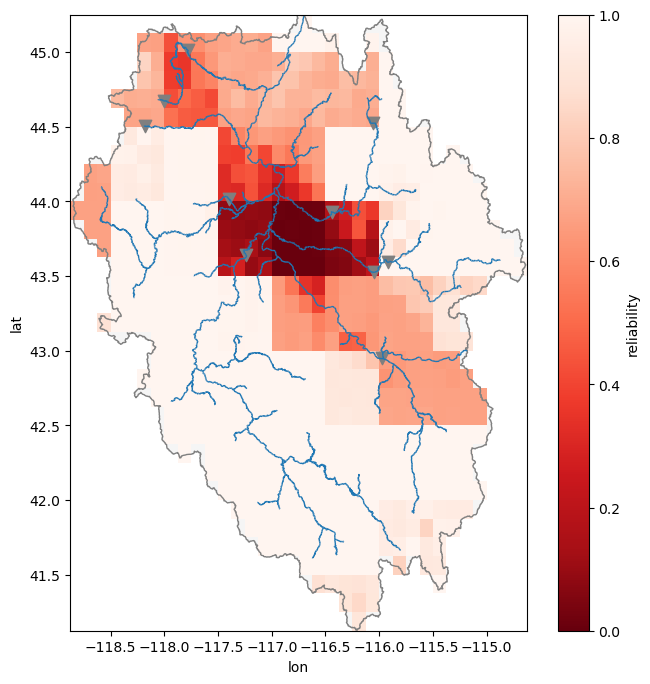

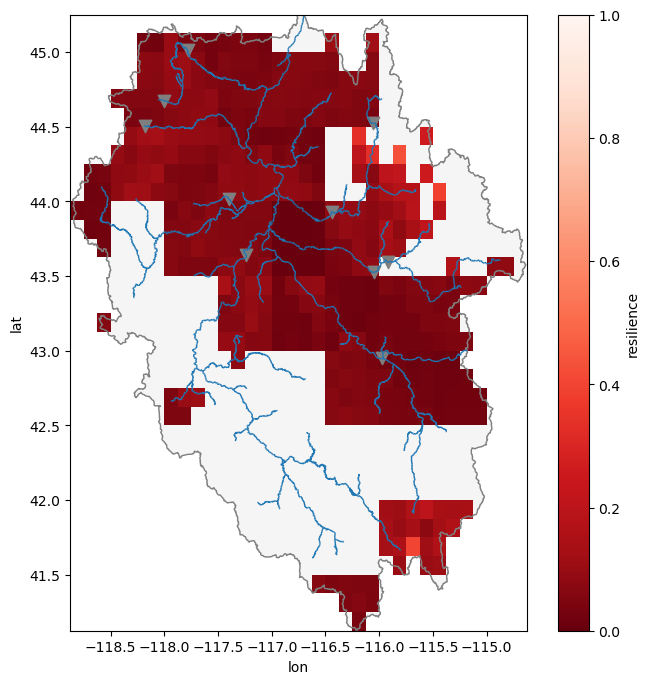

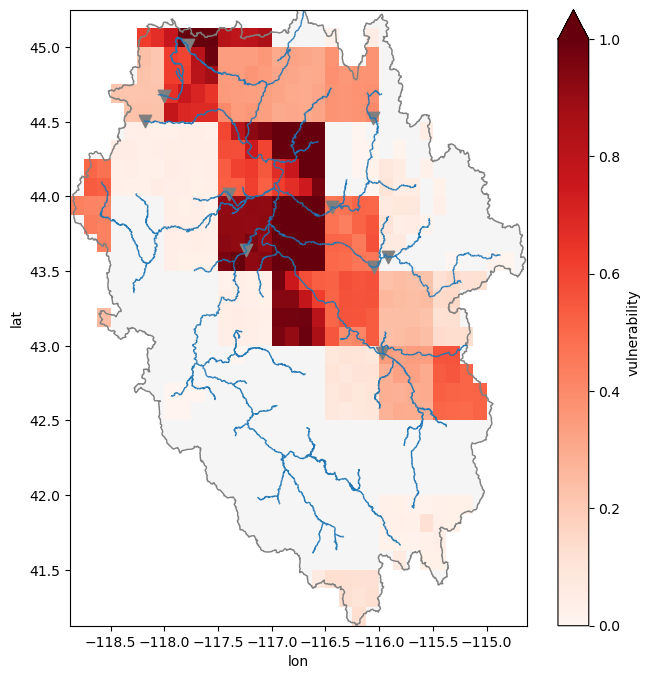

In [148]:
# ---- Plot ---- #

plot_dict = {'reliability': 'Reds_r', 'resilience': 'Reds_r', 'vulnerability': 'Reds'}

for sus_ind, cmap in plot_dict.items():

    fig, ax = plt.subplots(figsize=(8, 8))

    # plot huc4 basin as background
    gdf_huc4_all.loc[gdf_huc4_all['huc4']==huc4].plot(ax=ax, facecolor='whitesmoke', edgecolor='none')

    # plot flow lines
    max_order = gdf_flow_huc4['StreamOrde'].max()
    min_order_to_keep = 5
    gdf_flow_huc4.loc[gdf_flow_huc4['StreamOrde']>=min_order_to_keep].plot(ax=ax, linewidth=1, color='tab:blue')

    # plot sustainability index
    ds[sus_ind].plot(ax=ax, cmap=cmap, vmin=0, vmax=1, alpha=1)

    # plot huc4 basin
    gdf_huc4_all.loc[gdf_huc4_all['huc4']==huc4].plot(ax=ax, facecolor='none', edgecolor='gray')

    # plot reservoirs
    gdf_reservoirs.loc[gdf_reservoirs['huc4']==huc4].plot(ax=ax, color='tab:gray', marker='v', markersize=80)

    plt.savefig(f'{output_dir}/{huc4}/sustainability_index_{sus_ind}.png', dpi=300, bbox_inches='tight')

    plt.show()

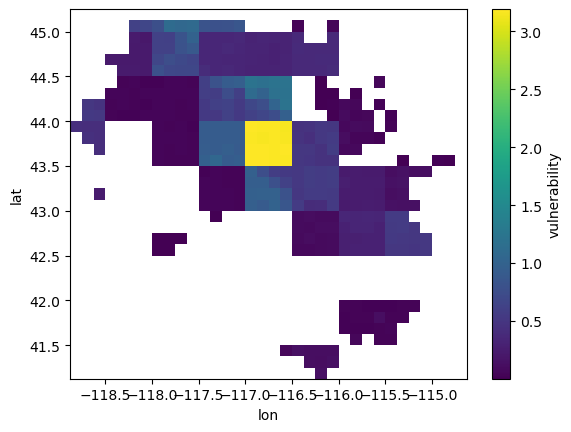

In [145]:
ds['vulnerability'].plot()
plt.show()

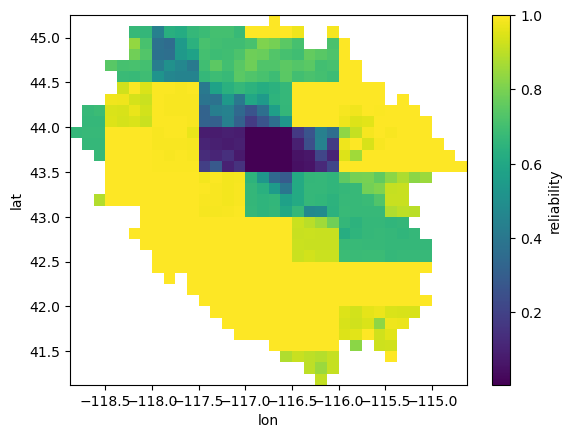

In [62]:
ds['reliability'].plot()
plt.show()

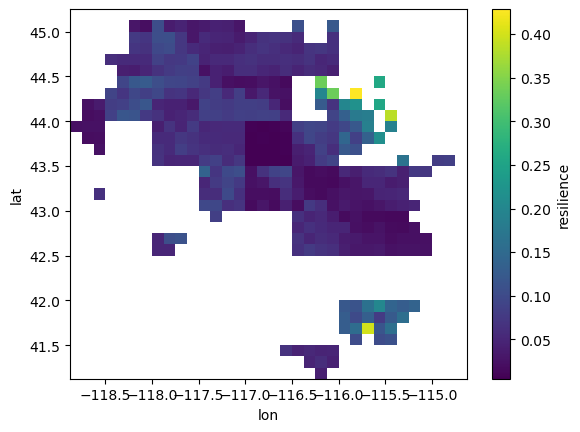

In [67]:
ds['resilience'].plot()
plt.show()

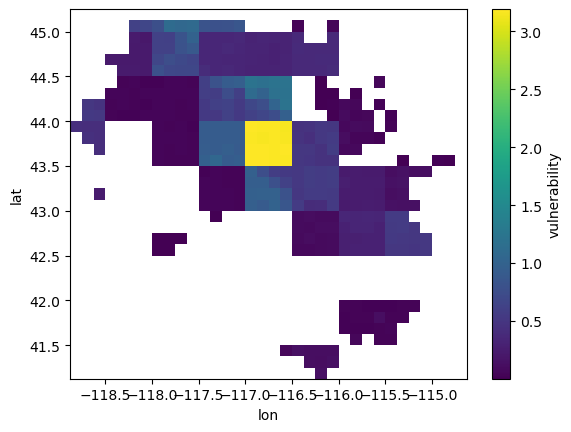

In [71]:
ds['vulnerability'].plot()
plt.show()



In [52]:
def cal_reliability(deficit_array, threshold=0.0001):
    """
    Calculate reliability of water deficit time series for a given grid.
    
    threshold: the threshold of water deficit, above which to be considered as a deficit
    """

    n_deficit = deficit_array[deficit_array > threshold].size

    return 1 - n_deficit / deficit_array.size

cal_reliability(deficit_array)

0.6693437984849868

In [51]:
deficit_array[deficit_array > 0.01].size

3621

In [5]:
ds

<xarray.Dataset>
Dimensions:                   (time: 10957, lat: 33, lon: 34)
Coordinates:
  * time                      (time) object '1990-01-01' ... '2019-12-31'
  * lat                       (lat) float32 41.19 41.31 41.44 ... 45.06 45.19
  * lon                       (lon) float32 -118.8 -118.7 ... -114.8 -114.7
Data variables:
    grid_id                   (lat, lon) int64 59906 59907 59908 ... 74786 74787
    reservoir_id              (lat, lon) int64 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    flow_direction            (lat, lon) int64 -1 -1 -1 -1 -1 ... -1 -1 -1 -1 -1
    reservoir_storage_start   (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    reservoir_storage_end     (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    outflow_before_operation  (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    outflow_after_operation   (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    grid_storage_start        (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    grid_storage_end          (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    total_water_demand        (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    water_deficit             (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0

In [5]:
ds

<xarray.Dataset>
Dimensions:                   (time: 11688, lat: 33, lon: 34)
Coordinates:
  * time                      (time) object '1988-01-01' ... '2019-12-31'
  * lat                       (lat) float32 41.19 41.31 41.44 ... 45.06 45.19
  * lon                       (lon) float32 -118.8 -118.7 ... -114.8 -114.7
Data variables:
    grid_id                   (lat, lon) int64 59906 59907 59908 ... 74786 74787
    reservoir_id              (lat, lon) int64 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    flow_direction            (lat, lon) int64 -1 -1 -1 -1 -1 ... -1 -1 -1 -1 -1
    reservoir_storage_start   (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    reservoir_storage_end     (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    outflow_before_operation  (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    outflow_after_operation   (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    grid_storage_start        (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    grid_storage_end          (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    total_water_demand        (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    water_deficit             (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0